In [1]:
# !pip install -U git+https://github.com/openfisca/openfisca-ceq.git@master#egg=OpenFisca-CEQ
# !pip install -U git+https://github.com/openfisca/openfisca-senegal.git@ceq#egg=OpenFisca-Senegal
# !pip install -U git+https://github.com/openfisca/openfisca-mali.git@master#egg=OpenFisca-Mali
# !pip install -U git+https://github.com/openfisca/openfisca-cote-d-ivoire.git@master#egg=OpenFisca-COTE-D-IVOIRE

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from openfisca_ceq.tools.survey_scenario import build_ceq_survey_scenario
from openfisca_ceq.tools.indirect_taxation.tax_benefit_system_indirect_taxation_completion import indirect_tax_by_country
from openfisca_ceq.tools.data import year_by_country
from openfisca_ceq.tools.data_ceq_correspondence import (
    ceq_input_by_harmonized_variable,
    ceq_intermediate_by_harmonized_variable,
    non_ceq_input_by_harmonized_variable,
    )

# Build country scenario

## Country selection

In [3]:
country = "mali"

In [4]:
# Parameters
country = "cote_d_ivoire"


In [5]:
year = year_by_country[country]
survey_scenario = build_ceq_survey_scenario(legislation_country = country, year = year)

/home/benjello/.virtualenvs/ceq/lib/python3.7/site-packages/pandas/io/stata.py:1409: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


# Aggegates check

## Income variables

### Disagregated income variables

In [6]:
ceq_by_harmonized_variable = dict()
ceq_by_harmonized_variable.update(ceq_input_by_harmonized_variable)
ceq_by_harmonized_variable.update(ceq_intermediate_by_harmonized_variable)
ceq_by_harmonized_variable.update(non_ceq_input_by_harmonized_variable)
ceq_by_harmonized_variable['autres_revenus_du_capital_brut'] = 'autres_revenus_du_capital_brut'
ceq_by_harmonized_variable['pension_retraite_brut'] = 'pension_retraite_brut'
ceq_by_harmonized_variable['revenu_foncier_brut'] = 'revenu_foncier_brut'
ceq_by_harmonized_variable['revenu_non_salarie_brut'] = 'revenu_non_salarie_brut' 
ceq_by_harmonized_variable['salaire_brut'] = 'salaire_brut'
ceq_by_harmonized_variable['salaire_super_brut'] = 'salaire_super_brut'
ceq_by_harmonized_variable

{'rev_i_autoconsommation': 'autoconsumption',
 'rev_i_autres': 'other_income',
 'rev_i_autres_transferts': 'gifts_sales_durables',
 'rev_i_loyers_imputes': 'imputed_rent',
 'rev_i_transferts_publics': 'direct_transfers',
 'rev_i_agricoles': 'revenu_agricole',
 'rev_i_autres_revenus_capital': 'autres_revenus_du_capital',
 'rev_i_independants_Ntaxe': 'revenu_informel_non_salarie',
 'rev_i_independants_taxe': 'revenu_non_salarie',
 'rev_i_locatifs': 'revenu_locatif',
 'rev_i_pensions': 'pension_retraite',
 'rev_i_salaires_formels': 'salaire',
 'rev_i_salaires_informels': 'revenu_informel_salarie',
 'autres_revenus_du_capital_brut': 'autres_revenus_du_capital_brut',
 'pension_retraite_brut': 'pension_retraite_brut',
 'revenu_foncier_brut': 'revenu_foncier_brut',
 'revenu_non_salarie_brut': 'revenu_non_salarie_brut',
 'salaire_brut': 'salaire_brut',
 'salaire_super_brut': 'salaire_super_brut'}

In [7]:
data = [
    (harmonized_variable, openfisca_variable, survey_scenario.compute_aggregate(openfisca_variable, period = year) / 1e9) 
    for harmonized_variable, openfisca_variable in ceq_by_harmonized_variable.items()
    ]

In [8]:
revenus = pd.DataFrame(data, columns = ["harmonized", "openfisca", "aggregate"])
revenus.round(0).astype({"aggregate": int})

,harmonized,openfisca,aggregate
0,rev_i_autoconsommation,autoconsumption,1289
1,rev_i_autres,other_income,581
2,rev_i_autres_transferts,gifts_sales_durables,782
3,rev_i_loyers_imputes,imputed_rent,277
4,rev_i_transferts_publics,direct_transfers,8
5,rev_i_agricoles,revenu_agricole,1428
6,rev_i_autres_revenus_capital,autres_revenus_du_capital,75
7,rev_i_independants_Ntaxe,revenu_informel_non_salarie,1346
8,rev_i_independants_taxe,revenu_non_salarie,245
9,rev_i_locatifs,revenu_locatif,215


### Agregated income variables

#### CEQ agregated income variables

In [9]:
ceq_variables = ["market_income", "market_income_plus_pensions", "pensions", "contributions_pensions", "net_market_income", "direct_taxes", "other_contributions", "contributions_health", ]

In [10]:
ceq_aggregates = pd.DataFrame(
    index = ceq_variables,
    columns = ['aggregate'],
    data = [
        survey_scenario.compute_aggregate(ceq_variable, period = year) / 1e9 
        for ceq_variable in ceq_variables
        ]
    )
ceq_aggregates.round(0).astype({"aggregate": int})

,aggregate
market_income,10325
market_income_plus_pensions,10465
pensions,354
contributions_pensions,214
net_market_income,10286
direct_taxes,179
other_contributions,53
contributions_health,0


#### Direct check

In [11]:
income_components_summed_in_total = list(ceq_by_harmonized_variable.values()) 
# income_components_summed_in_total.remove("revenu_non_salarie_total")
income_components_summed_in_total.remove("direct_transfers")
income_components_summed_in_total.remove("salaire")
income_components_summed_in_total.remove("salaire_brut")
income_components_summed_in_total.remove("pension_retraite")
income_components_summed_in_total.remove('autres_revenus_du_capital')
income_components_summed_in_total.remove('revenu_locatif')
income_components_summed_in_total.remove('revenu_non_salarie') 

total_income = sum(
    survey_scenario.compute_aggregate(income_component, period = survey_scenario.year) 
    for income_component in income_components_summed_in_total
    ) 
total_income = (
    total_income 
    - survey_scenario.compute_aggregate("contributions_pensions", period = survey_scenario.year)
    ) / 1e9


In [12]:
from numpy.testing import assert_almost_equal
assert_almost_equal(ceq_aggregates.loc['market_income_plus_pensions'].values, total_income, decimal = 5) 
# print('market_income_plus_pensions = {} vs {} = total_income'.format(
#         ceq_aggregates.loc['market_income_plus_pensions'].values,
#         total_income
#         )
#     )


#### Wages by public/private sector

In [13]:
"Count : {}".format(round(
    survey_scenario.compute_aggregate("secteur_public", period = year)
    ))

'Count : 245997.0'

In [14]:
(
    survey_scenario.compute_pivot_table(
        columns = ["secteur_public"], 
        values = ["salaire", "salaire_brut", "salaire_super_brut"],
        aggfunc = "sum",
        period = year,
        concat_axis = 0,
        ) / 1e9
    ).round(0).astype(int)

secteur_public,False,True
salaire,654,709
salaire_brut,781,835
salaire_super_brut,862,925


## Education variables

### Counts (in millions)

In [15]:
print((survey_scenario.compute_pivot_table(columns = ['eleve_enseignement_niveau'], index = ['eleve_enseignement_public'], aggfunc = 'count', period = survey_scenario.year) / 1e6).round(2))

eleve_enseignement_niveau   -1.0   0.0   1.0   2.0   3.0
eleve_enseignement_public                               
0.0                        18.12  0.06  0.54  0.55  0.07
1.0                          NaN  0.08  2.66  0.89  0.10


In [16]:
variables = [
    'pre_school_person',
    'pre_school',
    'primary_education_person',
    'primary_education',
    'secondary_education_person',
    'secondary_education',
    'tertiary_education_person',
    'tertiary_education',
    'education_net_transfers',
    ]
print("In kind education tranfers")
for variable in variables:
    print(
        "{variable}: {aggregate} billions FCFA".format(
            variable = variable,
            aggregate = int(round(survey_scenario.compute_aggregate(variable, period = survey_scenario.year) / 1e9))
            )
        )

In kind education tranfers
pre_school_person: 21 billions FCFA
pre_school: 21 billions FCFA
primary_education_person: 341 billions FCFA
primary_education: 341 billions FCFA
secondary_education_person: 309 billions FCFA
secondary_education: 309 billions FCFA
tertiary_education_person: 195 billions FCFA
tertiary_education: 195 billions FCFA
education_net_transfers: 866 billions FCFA


## Inflating income and consumption

In [17]:
inflated_survey_scenario = build_ceq_survey_scenario(
    legislation_country = country, 
    year = year,
    inflate = True,
    )

/home/benjello/.virtualenvs/ceq/lib/python3.7/site-packages/pandas/io/stata.py:1409: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


/home/benjello/.virtualenvs/ceq/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [18]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [19]:
from openfisca_ceq.tools.data.income_targets import read_target
gross_value_added = read_target(country, "gross_value_added") / 1e9
gross_value_added_computed = sum(inflated_survey_scenario.compute_aggregate(income_variable, period = year) / 1e9
    for income_variable in inflated_survey_scenario.income_variables
    )
display("{} == {}".format(gross_value_added, gross_value_added_computed))

'15635.476 == 15635.475591339304'

## Tax variables

### Direct taxes variables

In [20]:
from openfisca_ceq.tools.data.tax_targets import detailed_taxes_by_country, build_country_result
direct_taxes_variables = detailed_taxes_by_country[country]

direct_taxes = pd.concat(
    [
        pd.DataFrame(
            index = direct_taxes_variables,
            columns = ['aggregate'],
            data = [
                survey_scenario.compute_aggregate(variable, period = year) / 1e9 
                for variable in direct_taxes_variables
                ],
            ),
        pd.DataFrame(
            index = direct_taxes_variables,
            columns = ['inflated_aggregate'],
            data = [
                    inflated_survey_scenario.compute_aggregate(variable, period = year) / 1e9 
                for variable in direct_taxes_variables
                ],
            )
        ],
    axis = 1
)

direct_taxes.round().astype({"aggregate": int})

,aggregate,inflated_aggregate
impot_general_revenu,156,293.0
impot_revenu_creances,16,24.0
impot_revenu_foncier,7,10.0


In [21]:
build_country_result(survey_scenario, inflated_survey_scenario, add_country_details = True)

Cote d'Ivoire                 
                                                       actual  direct inflated
Total tax revenue                                      3117.9     NaN      NaN
Direct taxes                                           1186.8   178.9    326.9
Personal Income Taxes                                   395.6   178.9    326.9
Social Security Contributions                           383.5     NaN      NaN
Corporate Income Tax                                    318.9     0.0      0.0
Other Direct Taxes                                       88.8     NaN      NaN
Indirect taxes                                         1931.1   750.0    753.2
VAT                                                     732.5   559.4    561.8
Import Taxes                                            490.1   190.6    191.4
Excise taxes                                             33.1     0.0      0.0
on Oil Derivates                                          0.1     NaN      NaN
on alcohol, tabac and other non-oil derivatives          33.0     NaN      NaN
Other Indirect Taxes                                    675.4     NaN      NaN
Share simulated taxes (% of total tax revenue)            NaN     NaN      NaN
impot_general_revenu                                      NaN   155.8    293.2
impot_revenu_creances                                     NaN    16.4     24.0
impot_revenu_foncier                                      NaN     6.7      9.7
total_ht_imports                                          NaN  1329.4   1335.1

### Indirect tax variables

In [22]:
indirect_tax_variables = [
    variable 
    for tax in indirect_tax_by_country[country]
    for variable in survey_scenario.tax_benefit_system.variables.keys() 
    if tax in variable 
    ]
indirect_tax_variables

['depenses_ht_tva_exonere',
 'depenses_ht_tva_taux_normal',
 'depenses_ht_tva_taux_reduit',
 'tva_taux_normal',
 'tva_taux_reduit',
 'tva',
 'depenses_ht_hd_sd_droits_douane_biens_specifiques',
 'depenses_ht_hd_sd_droits_douane_consommation_finale',
 'depenses_ht_hd_sd_droits_douane_consommation_intermediaire',
 'depenses_ht_hd_sd_droits_douane_equipements',
 'depenses_ht_hd_sd_droits_douane_exonere',
 'droits_douane_biens_specifiques',
 'droits_douane_consommation_finale',
 'droits_douane_consommation_intermediaire',
 'droits_douane_equipements',
 'droits_douane']

In [23]:
taxes_and_tariffs = pd.DataFrame(
    index = indirect_tax_variables,
    columns = ['aggregate'],
    data = [
        survey_scenario.compute_aggregate(variable, period = year) / 1e9 
        for variable in indirect_tax_variables
        ]
    )
taxes_and_tariffs.round().astype({"aggregate": int})

,aggregate
depenses_ht_tva_exonere,7105
depenses_ht_tva_taux_normal,2923
depenses_ht_tva_taux_reduit,370
tva_taux_normal,526
tva_taux_reduit,33
tva,559
depenses_ht_hd_sd_droits_douane_biens_specifiques,162
depenses_ht_hd_sd_droits_douane_consommation_finale,617
depenses_ht_hd_sd_droits_douane_consommation_intermediaire,97
depenses_ht_hd_sd_droits_douane_equipements,12


### Verify consumption

In [24]:
consumption = survey_scenario.compute_aggregate('consumption', period = year) / 1e9
consumption

10957.287838906464

In [25]:
# assert consumption == 
sum(taxes_and_tariffs['aggregate'][
    taxes_and_tariffs.index.str.contains('tva_')
    ])

10957.288028355359

In [26]:
# assert consumption == 
(
    sum(
        survey_scenario.compute_aggregate(variable, period = year)
        for variable in survey_scenario.tax_benefit_system.variables
        if "depenses_ht_hd_poste" in variable 
        ) 
    + survey_scenario.compute_aggregate("droits_douane", period = year)
    + survey_scenario.compute_aggregate("tva", period = year)
    ) / 1e9

10957.28797724714

# Inflate incomes   

## Income variables

In [27]:
income_variables = [
    'autoconsumption',
    'other_income',
    'gifts_sales_durables',
    'imputed_rent',
    'revenu_agricole',
    'autres_revenus_du_capital',
    'revenu_informel_non_salarie',
    'revenu_non_salarie',
    'revenu_locatif',
    'pension_retraite',
    'salaire_super_brut',
    ]

In [28]:
sum(
    survey_scenario.compute_aggregate(income_variable, period = year)
    for income_variable in income_variables
    ) / 1e9

8378.641002137416

In [29]:
sum(
    inflated_survey_scenario.compute_aggregate(income_variable, period = year)
    for income_variable in income_variables
    ) / 1e9

11854.351449186952

# Indicators

In [30]:
from openfisca_survey_manager.statshelpers import lorenz
from openfisca_ceq.tools.results.inequality import inequality_table
display(inequality_table(survey_scenario))

,market_income,market_income_plus_pensions,gross_income,disposable_income,consumable_income,final_income
Gini,0.58,0.57,0.57,0.57,0.59,0.56
Bottom 40 %,0.09,0.09,0.09,0.09,0.08,0.10
Top 10 %,0.46,0.46,0.46,0.45,0.46,0.44


In [31]:
survey_scenario.compute_aggregate("impots_indirects", period = year) / 1e9

749.9915239734215

In [32]:
survey_scenario.compute_aggregate("direct_taxes", period = year) / 1e9

178.87436082048882

In [33]:
survey_scenario.compute_aggregate("personal_income_tax", period = year) / 1e9

178.87436082048882

In [34]:
from openfisca_ceq import list_variables_from_directory

In [35]:
ceq_variables = sorted(list_variables_from_directory(survey_scenario.tax_benefit_system))
[
    ceq_variable
    for ceq_variable in ceq_variables
    if survey_scenario.compute_aggregate(ceq_variable, period = year) == 0
    ]

['agricultural_inputs_subsidies',
 'alimony',
 'contributions_health',
 'corporate_income_tax',
 'electricity_subsidies',
 'employee_contributions_health',
 'employee_other_contributions',
 'employer_contributions_health',
 'excise_taxes',
 'food_subsidies',
 'fuel_subsidies',
 'indirect_subsidies',
 'other_taxes',
 'payroll_tax',
 'property_tax',
 'sales_tax',
 'self_employed_contributions_health',
 'self_employed_contributions_pensions',
 'self_employed_other_contributions']

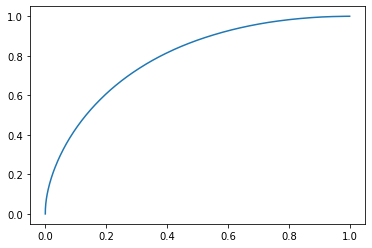

In [36]:
variable = "market_income"
nb_persons = survey_scenario.calculate_variable("number_of_people_per_household", period = year)
weights = survey_scenario.calculate_variable("household_weight", period = year) * nb_persons

y, x = lorenz(survey_scenario.calculate_variable(variable, period = year) / nb_persons, weights = weights)
plt.plot(x, y)

In [37]:
survey_scenario.compute_aggregate('direct_transfers', period = year) / 1e9

8.438274100199402

In [38]:
ceq_variables

['agricultural_inputs_subsidies',
 'alimony',
 'all_income_excluding_transfers',
 'autoconsumption',
 'consumable_income',
 'contributions_health',
 'contributions_pensions',
 'corporate_income_tax',
 'customs_duties',
 'decile_consumable_income_per_capita',
 'decile_disposable_income_per_capita',
 'decile_final_income_per_capita',
 'decile_gross_income_per_capita',
 'decile_market_income_per_capita',
 'decile_market_income_plus_pensions_per_capita',
 'decile_survey_income_per_capita',
 'direct_taxes',
 'disposable_income',
 'electricity_subsidies',
 'employee_contributions_health',
 'employee_contributions_pensions',
 'employee_other_contributions',
 'employer_contributions_health',
 'employer_contributions_pensions',
 'employer_other_contributions',
 'excise_taxes',
 'final_income',
 'food_subsidies',
 'fuel_subsidies',
 'gifts_sales_durables',
 'gross_income',
 'imputed_rent',
 'indirect_subsidies',
 'indirect_taxes',
 'market_income',
 'market_income_plus_pensions',
 'net_market_in

In [39]:
survey_scenario.compute_aggregate('customs_duties', period = year) 

190588786862.95657

In [40]:
inflated_survey_scenario = build_ceq_survey_scenario(legislation_country = country, year = year, inflate = True)

/home/benjello/.virtualenvs/ceq/lib/python3.7/site-packages/pandas/io/stata.py:1409: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


/home/benjello/.virtualenvs/ceq/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [41]:
sorted([
    variable 
    for variable in survey_scenario.tax_benefit_system.variables 
    if variable.startswith('poste_')
    ])

['poste_10_1',
 'poste_10_1_1_1_item_1',
 'poste_10_1_1_1_item_2',
 'poste_10_1_1_1_item_3',
 'poste_10_1_1_1_item_4',
 'poste_10_1_1_1_item_5',
 'poste_11_1_1_1_1',
 'poste_11_1_1_1_2',
 'poste_11_1_2_1_1',
 'poste_12_1_1_1',
 'poste_12_1_3_item_1',
 'poste_12_1_3_item_2',
 'poste_12_3_1_1',
 'poste_12_5',
 'poste_12_5_3_1_1',
 'poste_12_7_1',
 'poste_12_7_1_2_3_item_1',
 'poste_12_7_1_2_3_item_2',
 'poste_12_7_1_2_3_item_3',
 'poste_12_7_1_2_3_item_4',
 'poste_12_7_1_2_3_item_5',
 'poste_1_1',
 'poste_1_1_1_1_1',
 'poste_1_1_1_3_2',
 'poste_1_1_1_4_1_item_1',
 'poste_1_1_1_4_1_item_10',
 'poste_1_1_1_4_1_item_11',
 'poste_1_1_1_4_1_item_12',
 'poste_1_1_1_4_1_item_13',
 'poste_1_1_1_4_1_item_14',
 'poste_1_1_1_4_1_item_15',
 'poste_1_1_1_4_1_item_16',
 'poste_1_1_1_4_1_item_2',
 'poste_1_1_1_4_1_item_3',
 'poste_1_1_1_4_1_item_4',
 'poste_1_1_1_4_1_item_5',
 'poste_1_1_1_4_1_item_6',
 'poste_1_1_1_4_1_item_7',
 'poste_1_1_1_4_1_item_8',
 'poste_1_1_1_4_1_item_9',
 'poste_1_1_1_4_2',


In [42]:
survey_scenario.compute_aggregate('indirect_taxes', period = year)

749991523973.4215

Direct taxes